In [1]:
import pandas as pd
import numpy as np
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules




In [2]:
# Read the dataset
df = pd.read_excel('data/Final_Test_Cleaned_DF.xlsx')


In [3]:
df.shape

(2040, 6)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Geolocation       2040 non-null   object 
 1   Major Occupation  2040 non-null   object 
 2   Year              2040 non-null   int64  
 3   Quarter           2040 non-null   object 
 4   Female            2040 non-null   float64
 5   Male              2040 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 95.8+ KB


In [5]:
# Make the Year into a string
df['Year'] = df['Year'].astype(str)


In [6]:
# Display the dataset using the year and quarter columns
df[['Year', 'Quarter']].value_counts()

Year  Quarter
2019  Q1         170
      Q2         170
      Q3         170
      Q4         170
2020  Q1         170
      Q2         170
      Q3         170
      Q4         170
2021  Q1         170
      Q2         170
      Q3         170
      Q4         170
Name: count, dtype: int64

In [7]:

# Function to create binary columns for each unique value in specified columns
def create_binary_columns(df, columns):
    binary_df = pd.DataFrame()
    
    for col in columns:
        unique_values = df[col].unique()
        for value in unique_values:
            binary_df[f"{col}_{value}"] = (df[col] == value).astype(int)
    
    return binary_df

# Preprocess the data
# Create binary columns for Geolocation and Major Occupation
columns_to_binarize = ['Geolocation', 'Major Occupation']
binary_df = create_binary_columns(df, columns_to_binarize)

# Calculate combined min and max for both genders to create a standard range
min_employment = min(df['Female'].min(), df['Male'].min())
max_employment = max(df['Female'].max(), df['Male'].max())

# Create bins using the combined range
bins = [min_employment, 
       min_employment + (max_employment-min_employment)/4, 
       min_employment + 2*(max_employment-min_employment)/4, 
       min_employment + 3*(max_employment-min_employment)/4, 
       max_employment]
labels = ['Low', 'Medium-Low', 'Medium-High', 'High']

# Assign levels based on the standard range
df['Female_Level'] = pd.cut(df['Female'], bins=bins, labels=labels)
df['Male_Level'] = pd.cut(df['Male'], bins=bins, labels=labels)

# Print the standard employment level ranges
print("\nStandard Employment Level Ranges:")
for i in range(len(labels)):
    print(f"{labels[i]}: {bins[i]} to {bins[i+1]}")


binary_df = pd.concat([
    binary_df,
    pd.get_dummies(df['Female_Level'], prefix='Female'),
    pd.get_dummies(df['Male_Level'], prefix='Male'),
    pd.get_dummies(df['Year'], prefix='Year'),
    pd.get_dummies(df['Quarter'], prefix='Quarter')
], axis=1)

#Print the dataframe shape before using FP-Growth
print("\nDataFrame shape before FP-Growth:")
print(binary_df.shape)





# Generate frequent itemsets using FP-Growth
min_support = 0.01 # Minimum support threshold (1%)
frequent_itemsets = fpgrowth(binary_df, min_support=min_support, use_colnames=True)

# Generate association rules
min_confidence = 0.6  # Minimum confidence threshold (50%)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=min_confidence)

# Sort rules by lift (measure of rule strength)
rules = rules.sort_values('lift', ascending=False)




Standard Employment Level Ranges:
Low: 0.0 to 289.088
Medium-Low: 289.088 to 578.176
Medium-High: 578.176 to 867.2640000000001
High: 867.2640000000001 to 1156.352

DataFrame shape before FP-Growth:
(2040, 42)


c:\Users\rojgi\AppData\Local\Programs\Python\Python310\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [8]:

# Display the top 20 rules
print("\nTop 20 Association Rules:")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
print(rules.head(20))

# Save results to Excel
rules.to_excel('employment_association_rules.xlsx', index=False)
print("\nResults have been saved to 'employment_association_rules.xlsx'")


rules



Top 20 Association Rules:
                                           antecedents  \
633                               (Female_Medium-High)   
631                      (Male_Low, Female_Medium-Low)   
173  (Quarter_Q3, Major Occupation_Elementary Occup...   
181  (Major Occupation_Elementary Occupations, Year...   
401  (Major Occupation_Technicians and Associate Pr...   
521                      (Quarter_Q1, Geolocation_CAR)   
546                       (Year_2021, Geolocation_CAR)   
436  (Year_2021, Major Occupation_Technicians and A...   
431  (Major Occupation_Technicians and Associate Pr...   
426  (Quarter_Q4, Major Occupation_Technicians and ...   
421  (Quarter_Q3, Major Occupation_Technicians and ...   
536                      (Quarter_Q4, Geolocation_CAR)   
411  (Quarter_Q1, Major Occupation_Technicians and ...   
406  (Year_2019, Major Occupation_Technicians and A...   
416  (Major Occupation_Technicians and Associate Pr...   
278       (Major Occupation_Professionals, Qu

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
633,(Female_Medium-High),(Major Occupation_Service and Sales Workers),0.012745,0.100000,0.012255,0.961538,9.615385,1.0,0.010980,23.400000,0.907567,0.121951,0.957265,0.542044
631,"(Male_Low, Female_Medium-Low)",(Major Occupation_Service and Sales Workers),0.025490,0.100000,0.015686,0.615385,6.153846,1.0,0.013137,2.340000,0.859406,0.142857,0.572650,0.386124
173,"(Quarter_Q3, Major Occupation_Elementary Occup...",(Male_Medium-Low),0.018137,0.137255,0.011765,0.648649,4.725869,1.0,0.009275,2.455505,0.802962,0.081911,0.592752,0.367181
181,"(Major Occupation_Elementary Occupations, Year...",(Male_Medium-Low),0.024020,0.137255,0.014706,0.612245,4.460641,1.0,0.011409,2.224974,0.794910,0.100334,0.550557,0.359694
401,(Major Occupation_Technicians and Associate Pr...,"(Male_Low, Female_Low)",0.100000,0.741176,0.100000,1.000000,1.349206,1.0,0.025882,inf,0.287582,0.134921,1.000000,0.567460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,(Geolocation_REGION IVA),(Female_Low),0.058824,0.859804,0.036765,0.625000,0.726910,1.0,-0.013812,0.373856,-0.285289,0.041690,-1.674825,0.333880
714,(Geolocation_REGION III),(Male_Low),0.058824,0.829412,0.035294,0.600000,0.723404,1.0,-0.013495,0.426471,-0.288889,0.041379,-1.344828,0.321277
731,"(Geolocation_REGION III, Year_2021)",(Male_Low),0.019608,0.829412,0.011765,0.600000,0.723404,1.0,-0.004498,0.426471,-0.280576,0.014052,-1.344828,0.307092
740,"(Geolocation_REGION IVA, Year_2021)",(Male_Low),0.019608,0.829412,0.011765,0.600000,0.723404,1.0,-0.004498,0.426471,-0.280576,0.014052,-1.344828,0.307092


In [9]:
# Additional analysis: Find specific patterns
# 1. Rules related to gender employment levels
gender_rules = rules[rules['antecedents'].astype(str).str.contains('Female|Male') | 
                    rules['consequents'].astype(str).str.contains('Female|Male')]
print("\nTop 10 Gender-related Rules:")
print(gender_rules.head(10))

# 2. Region-specific patterns
region_rules = rules[rules['antecedents'].astype(str).str.contains('Geolocation') | 
                    rules['consequents'].astype(str).str.contains('Geolocation')]
print("\nTop 10 Region-specific Rules:")
print(region_rules.head(10)) 


Top 10 Gender-related Rules:
                                           antecedents  \
633                               (Female_Medium-High)   
631                      (Male_Low, Female_Medium-Low)   
173  (Quarter_Q3, Major Occupation_Elementary Occup...   
181  (Major Occupation_Elementary Occupations, Year...   
401  (Major Occupation_Technicians and Associate Pr...   
521                      (Quarter_Q1, Geolocation_CAR)   
546                       (Year_2021, Geolocation_CAR)   
436  (Year_2021, Major Occupation_Technicians and A...   
431  (Major Occupation_Technicians and Associate Pr...   
426  (Quarter_Q4, Major Occupation_Technicians and ...   

                                      consequents  antecedent support  \
633  (Major Occupation_Service and Sales Workers)            0.012745   
631  (Major Occupation_Service and Sales Workers)            0.025490   
173                             (Male_Medium-Low)            0.018137   
181                             (Male_M

In [10]:


#Filter gender rules that displays gender disparities in employment
gender_rules = rules[(rules['confidence'] > 0.8) & (rules['antecedents'].astype(str).str.contains('Female|Male'))]

gender_rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
633,(Female_Medium-High),(Major Occupation_Service and Sales Workers),0.012745,0.100000,0.012255,0.961538,9.615385,1.0,0.010980,23.400000,0.907567,0.121951,0.957265,0.542044
297,"(Major Occupation_Professionals, Female_Low, Y...",(Male_Low),0.033333,0.829412,0.033333,1.000000,1.205674,1.0,0.005686,inf,0.176471,0.040189,1.000000,0.520095
302,"(Major Occupation_Professionals, Year_2021, Fe...",(Male_Low),0.031863,0.829412,0.031863,1.000000,1.205674,1.0,0.005435,inf,0.176203,0.038416,1.000000,0.519208
534,"(Quarter_Q4, Geolocation_CAR, Female_Low)",(Male_Low),0.014706,0.829412,0.014706,1.000000,1.205674,1.0,0.002509,inf,0.173134,0.017730,1.000000,0.508865
580,"(Geolocation_CARAGA, Female_Low, Year_2020)",(Male_Low),0.018137,0.829412,0.018137,1.000000,1.205674,1.0,0.003094,inf,0.173739,0.021868,1.000000,0.510934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,"(Quarter_Q1, Male_Medium-Low)",(Female_Low),0.033824,0.859804,0.027451,0.811594,0.943929,1.0,-0.001631,0.744118,-0.057920,0.031692,-0.343874,0.421761
180,"(Major Occupation_Elementary Occupations, Year...",(Female_Low),0.018137,0.859804,0.014706,0.810811,0.943018,1.0,-0.000889,0.741036,-0.057973,0.017036,-0.349461,0.413957
306,"(Male_Low, Major Occupation_Service and Sales ...",(Female_Low),0.081863,0.859804,0.066176,0.808383,0.940195,1.0,-0.004209,0.731648,-0.064792,0.075588,-0.366777,0.442675
350,"(Male_Medium-Low, Quarter_Q3, Year_2020)",(Female_Low),0.012745,0.859804,0.010294,0.807692,0.939391,1.0,-0.000664,0.729020,-0.061343,0.011939,-0.371705,0.409832


In [11]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np
# from matplotlib.ticker import MaxNLocator
# import re

# # Set style for better visualizations
# plt.style.use('seaborn-v0_8-whitegrid')
# sns.set_palette("Set2")

# # Load the association rules
# rules_df = pd.read_excel('data/employment_association_rules.xlsx')

# # Function to check if a rule is gender-related
# def is_gender_related(rule_antecedents, rule_consequents):
#     antecedents_str = str(rule_antecedents)
#     consequents_str = str(rule_consequents)
    
#     # Check if rule mentions gender levels (Female or Male)
#     gender_patterns = ['Female_', 'Male_']
    
#     for pattern in gender_patterns:
#         if pattern in antecedents_str or pattern in consequents_str:
#             return True
    
#     return False

# # Extract gender-related rules
# gender_rules = rules_df[rules_df.apply(lambda x: is_gender_related(x['antecedents'], x['consequents']), axis=1)]

# # Sort by lift (measure of rule strength) and take top 15
# top_gender_rules = gender_rules.sort_values('lift', ascending=False).head(15)

# # Clean rule text for better display
# def clean_rule_text(rule_text):
#     # Remove frozenset syntax and clean up
#     cleaned = str(rule_text).replace('frozenset({', '').replace('})', '')
#     # Remove quotes
#     cleaned = cleaned.replace("'", "")
#     # Add line breaks for long rules
#     if len(cleaned) > 30:
#         parts = cleaned.split(', ')
#         cleaned = '\n'.join(parts)
#     return cleaned

# # Create more readable rule descriptions
# rule_descriptions = []
# for i, row in top_gender_rules.iterrows():
#     antecedent = clean_rule_text(row['antecedents'])
#     consequent = clean_rule_text(row['consequents'])
#     rule_descriptions.append(f"{antecedent} → {consequent}")

# # Create figure for the bar chart
# plt.figure(figsize=(12, 8))

# # Plot horizontal bar chart
# bars = plt.barh(range(len(top_gender_rules)), top_gender_rules['lift'], color=sns.color_palette("Set2", n_colors=15))

# # Add rule descriptions as y-axis labels
# plt.yticks(range(len(top_gender_rules)), rule_descriptions)

# # Add data labels to the bars
# for i, bar in enumerate(bars):
#     confidence = top_gender_rules.iloc[i]['confidence']
#     plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
#              f'Conf: {confidence:.2f}', va='center')

# # Add a title and labels
# plt.title('Top 15 Gender-Related Association Rules by Lift', fontsize=16, pad=20)
# plt.xlabel('Lift (Rule Strength)', fontsize=12)
# plt.ylabel('Rules (Antecedent → Consequent)', fontsize=12)
# plt.xlim(0, max(top_gender_rules['lift']) * 1.15)  # Add some padding for the text labels

# # Add a grid for better readability
# plt.grid(axis='x', linestyle='--', alpha=0.7)

# # Tight layout to make everything fit
# plt.tight_layout()

# # Save and show the figure
# plt.savefig('top_gender_rules.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Create a second visualization for confidence
# plt.figure(figsize=(12, 8))

# # Get top rules by confidence
# top_by_confidence = gender_rules.sort_values(['confidence', 'lift'], ascending=[False, False]).head(15)

# # Create readable rule descriptions
# conf_rule_descriptions = []
# for i, row in top_by_confidence.iterrows():
#     antecedent = clean_rule_text(row['antecedents'])
#     consequent = clean_rule_text(row['consequents'])
#     conf_rule_descriptions.append(f"{antecedent} → {consequent}")

# # Plot horizontal bar chart
# bars = plt.barh(range(len(top_by_confidence)), top_by_confidence['confidence'], color=sns.color_palette("Blues_r", n_colors=15))

# # Add rule descriptions as y-axis labels
# plt.yticks(range(len(top_by_confidence)), conf_rule_descriptions)

# # Add data labels to the bars
# for i, bar in enumerate(bars):
#     lift = top_by_confidence.iloc[i]['lift']
#     plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, 
#              f'Lift: {lift:.2f}', va='center')

# # Add a title and labels
# plt.title('Top 15 Gender-Related Association Rules by Confidence', fontsize=16, pad=20)
# plt.xlabel('Confidence', fontsize=12)
# plt.ylabel('Rules (Antecedent → Consequent)', fontsize=12)
# plt.xlim(0, 1.1)  # Confidence is always between 0 and 1

# # Add a grid for better readability
# plt.grid(axis='x', linestyle='--', alpha=0.7)

# # Tight layout to make everything fit
# plt.tight_layout()

# # Save and show the figure
# plt.savefig('top_gender_rules_by_confidence.png', dpi=300, bbox_inches='tight')
# plt.show()

# # Create a comparison chart showing top rules by support
# plt.figure(figsize=(14, 10))

# # Get top rules by support
# top_by_support = gender_rules.sort_values(['support', 'lift'], ascending=[False, False]).head(10)

# # Create rule descriptions
# support_rule_descriptions = []
# for i, row in top_by_support.iterrows():
#     antecedent = clean_rule_text(row['antecedents'])
#     consequent = clean_rule_text(row['consequents'])
#     support_rule_descriptions.append(f"{antecedent} → {consequent}")

# # Create a bar chart with multiple metrics
# x = np.arange(len(support_rule_descriptions))
# width = 0.25

# fig, ax = plt.subplots(figsize=(14, 10))
# rects1 = ax.bar(x - width, top_by_support['support'], width, label='Support', color='skyblue')
# rects2 = ax.bar(x, top_by_support['confidence'], width, label='Confidence', color='lightgreen')
# rects3 = ax.bar(x + width, top_by_support['lift']/max(top_by_support['lift']), width, label='Normalized Lift', color='salmon')

# # Add labels and title
# ax.set_xlabel('Rules', fontsize=12)
# ax.set_ylabel('Metric Value', fontsize=12)
# ax.set_title('Comparison of Support, Confidence, and Lift for Top Gender Rules', fontsize=16)
# ax.set_xticks(x)
# ax.set_xticklabels(support_rule_descriptions, rotation=45, ha='right')
# ax.legend()

# # Adjust layout
# fig.tight_layout()

# # Save the figure
# plt.savefig('gender_rules_metrics_comparison.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("Visualizations have been created and saved!") 

In [12]:
region_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
521,"(Quarter_Q1, Geolocation_CAR)","(Male_Low, Female_Low)",0.014706,0.741176,0.014706,1.000,1.349206,1.0,0.003806,inf,0.262687,0.019841,1.000000,0.509921
546,"(Year_2021, Geolocation_CAR)","(Male_Low, Female_Low)",0.019608,0.741176,0.019608,1.000,1.349206,1.0,0.005075,inf,0.264000,0.026455,1.000000,0.513228
536,"(Quarter_Q4, Geolocation_CAR)","(Male_Low, Female_Low)",0.014706,0.741176,0.014706,1.000,1.349206,1.0,0.003806,inf,0.262687,0.019841,1.000000,0.509921
586,"(Geolocation_CARAGA, Year_2021)","(Male_Low, Female_Low)",0.019608,0.741176,0.019608,1.000,1.349206,1.0,0.005075,inf,0.264000,0.026455,1.000000,0.513228
541,"(Geolocation_CAR, Year_2020)","(Male_Low, Female_Low)",0.019608,0.741176,0.019118,0.975,1.315476,1.0,0.004585,10.352941,0.244615,0.025777,0.903409,0.500397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
734,(Geolocation_REGION IVA),(Female_Low),0.058824,0.859804,0.036765,0.625,0.726910,1.0,-0.013812,0.373856,-0.285289,0.041690,-1.674825,0.333880
714,(Geolocation_REGION III),(Male_Low),0.058824,0.829412,0.035294,0.600,0.723404,1.0,-0.013495,0.426471,-0.288889,0.041379,-1.344828,0.321277
731,"(Geolocation_REGION III, Year_2021)",(Male_Low),0.019608,0.829412,0.011765,0.600,0.723404,1.0,-0.004498,0.426471,-0.280576,0.014052,-1.344828,0.307092
740,"(Geolocation_REGION IVA, Year_2021)",(Male_Low),0.019608,0.829412,0.011765,0.600,0.723404,1.0,-0.004498,0.426471,-0.280576,0.014052,-1.344828,0.307092


In [13]:
# Create association rules for Identifying Employment Trends
# Identify employment trends over time
time_rules = rules[rules['antecedents'].astype(str).str.contains('Year|Quarter') | 
                   rules['consequents'].astype(str).str.contains('Year|Quarter')]

print("\nTop Employment Trends Over Time:")
print(time_rules.head(10))

# Identify occupation-related trends
occupation_rules = rules[rules['antecedents'].astype(str).str.contains('Major Occupation') | 
                         rules['consequents'].astype(str).str.contains('Major Occupation')]

print("\nTop Occupation-related Trends:")
print(occupation_rules.head(10))

# Find rules with high confidence and lift (strong employment trends)
strong_trends = rules[(rules['confidence'] > 0.8) & (rules['lift'] > 3)]
print("\nStrong Employment Trends (High Confidence & Lift):")
print(strong_trends.head(10))

# Analyze year-to-year employment changes
year_transition_rules = rules[
    (rules['antecedents'].astype(str).str.contains('Year_2019') & 
     rules['consequents'].astype(str).str.contains('Year_2020')) |
    (rules['antecedents'].astype(str).str.contains('Year_2020') & 
     rules['consequents'].astype(str).str.contains('Year_2021'))
]
print("\nYear-to-Year Employment Transitions:")
year_transition_rules







Top Employment Trends Over Time:
                                           antecedents  \
173  (Quarter_Q3, Major Occupation_Elementary Occup...   
181  (Major Occupation_Elementary Occupations, Year...   
521                      (Quarter_Q1, Geolocation_CAR)   
546                       (Year_2021, Geolocation_CAR)   
436  (Year_2021, Major Occupation_Technicians and A...   
431  (Major Occupation_Technicians and Associate Pr...   
426  (Quarter_Q4, Major Occupation_Technicians and ...   
421  (Quarter_Q3, Major Occupation_Technicians and ...   
536                      (Quarter_Q4, Geolocation_CAR)   
411  (Quarter_Q1, Major Occupation_Technicians and ...   

                consequents  antecedent support  consequent support   support  \
173       (Male_Medium-Low)            0.018137            0.137255  0.011765   
181       (Male_Medium-Low)            0.024020            0.137255  0.014706   
521  (Male_Low, Female_Low)            0.014706            0.741176  0.014706   
546

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski


In [14]:
# Interpret the gender rules showing gender disparities in employment

# Filter rules that show relationships between gender and occupation
gender_occupation_rules = gender_rules[
    (gender_rules['antecedents'].astype(str).str.contains('Female|Male')) & 
    (gender_rules['consequents'].astype(str).str.contains('Major Occupation'))
]

print("\nGender-Occupation Relationships:")
print(gender_occupation_rules.head(10))

# Analyze gender disparities by region
gender_region_rules = gender_rules[
    (gender_rules['antecedents'].astype(str).str.contains('Female|Male')) & 
    (gender_rules['consequents'].astype(str).str.contains('Geolocation'))
]

print("\nGender-Region Relationships:")
print(gender_region_rules.head(10))

# Compare high confidence rules for different gender categories
female_high_rules = gender_rules[gender_rules['antecedents'].astype(str).str.contains('Female_Medium-High|Female_High')]
male_high_rules = gender_rules[gender_rules['antecedents'].astype(str).str.contains('Male_Medium-High|Male_High')]

print("\nHigh-level Female Employment Patterns:")
print(female_high_rules.head(5))

print("\nHigh-level Male Employment Patterns:")
print(male_high_rules.head(5))

# Identify gender imbalance trends over time
gender_time_rules = gender_rules[
    (gender_rules['antecedents'].astype(str).str.contains('Female|Male')) & 
    (gender_rules['consequents'].astype(str).str.contains('Year|Quarter'))
]

print("\nGender Employment Trends Over Time:")
gender_time_rules



Gender-Occupation Relationships:
              antecedents                                   consequents  \
633  (Female_Medium-High)  (Major Occupation_Service and Sales Workers)   

     antecedent support  consequent support   support  confidence      lift  \
633            0.012745                 0.1  0.012255    0.961538  9.615385   

     representativity  leverage  conviction  zhangs_metric   jaccard  \
633               1.0   0.01098        23.4       0.907567  0.121951   

     certainty  kulczynski  
633   0.957265    0.542044  

Gender-Region Relationships:
Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, representativity, leverage, conviction, zhangs_metric, jaccard, certainty, kulczynski]
Index: []

High-level Female Employment Patterns:
              antecedents                                   consequents  \
633  (Female_Medium-High)  (Major Occupation_Service and Sales Workers)   

     antecedent 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski



NETWORK VISUALIZATION OF GENDER-RELATED RULES

NETWORK VISUALIZATION OF GENDER DISPARITY RULES


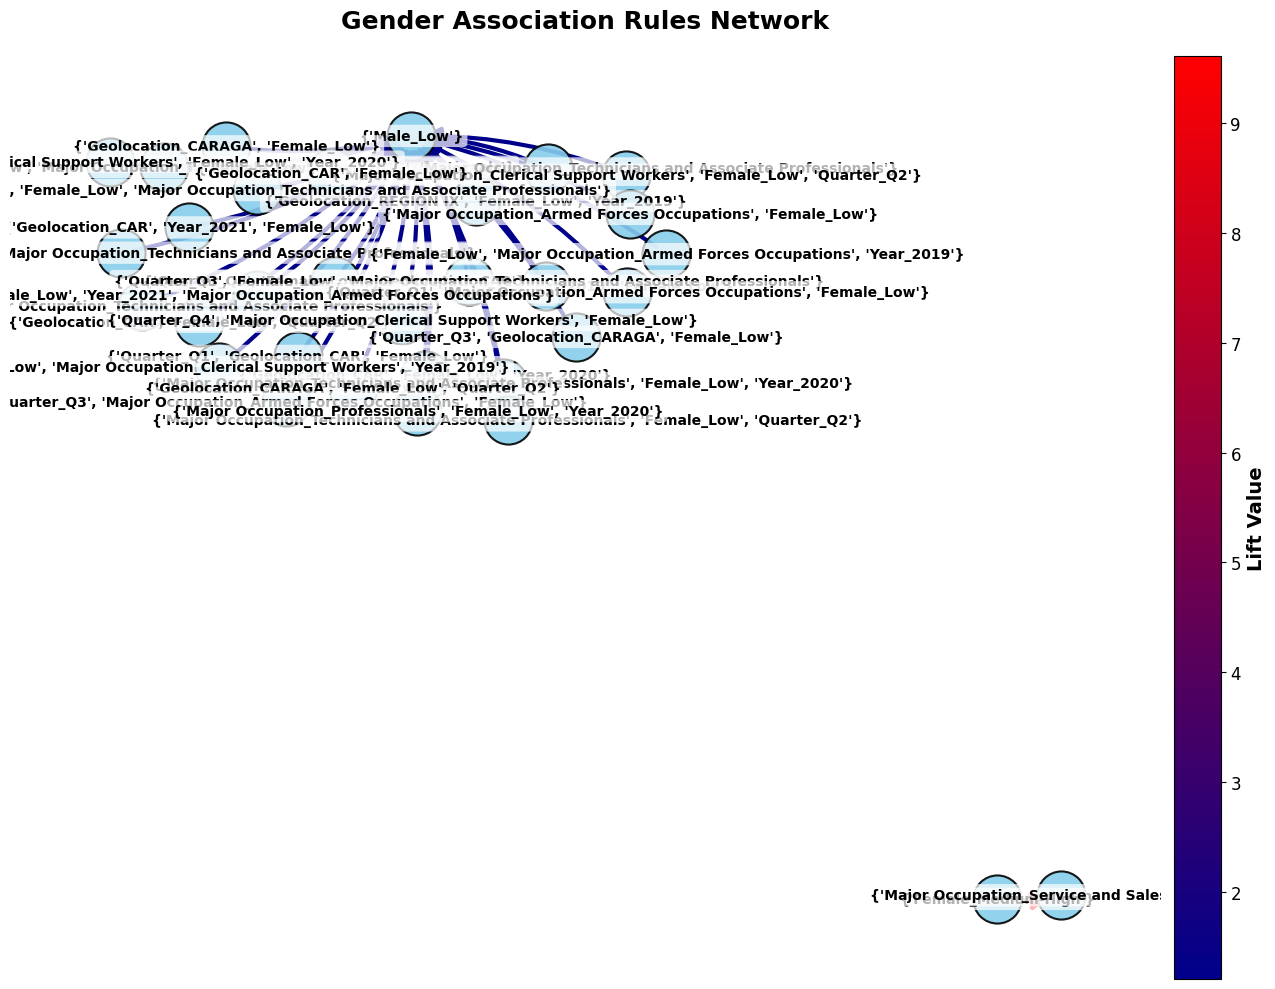

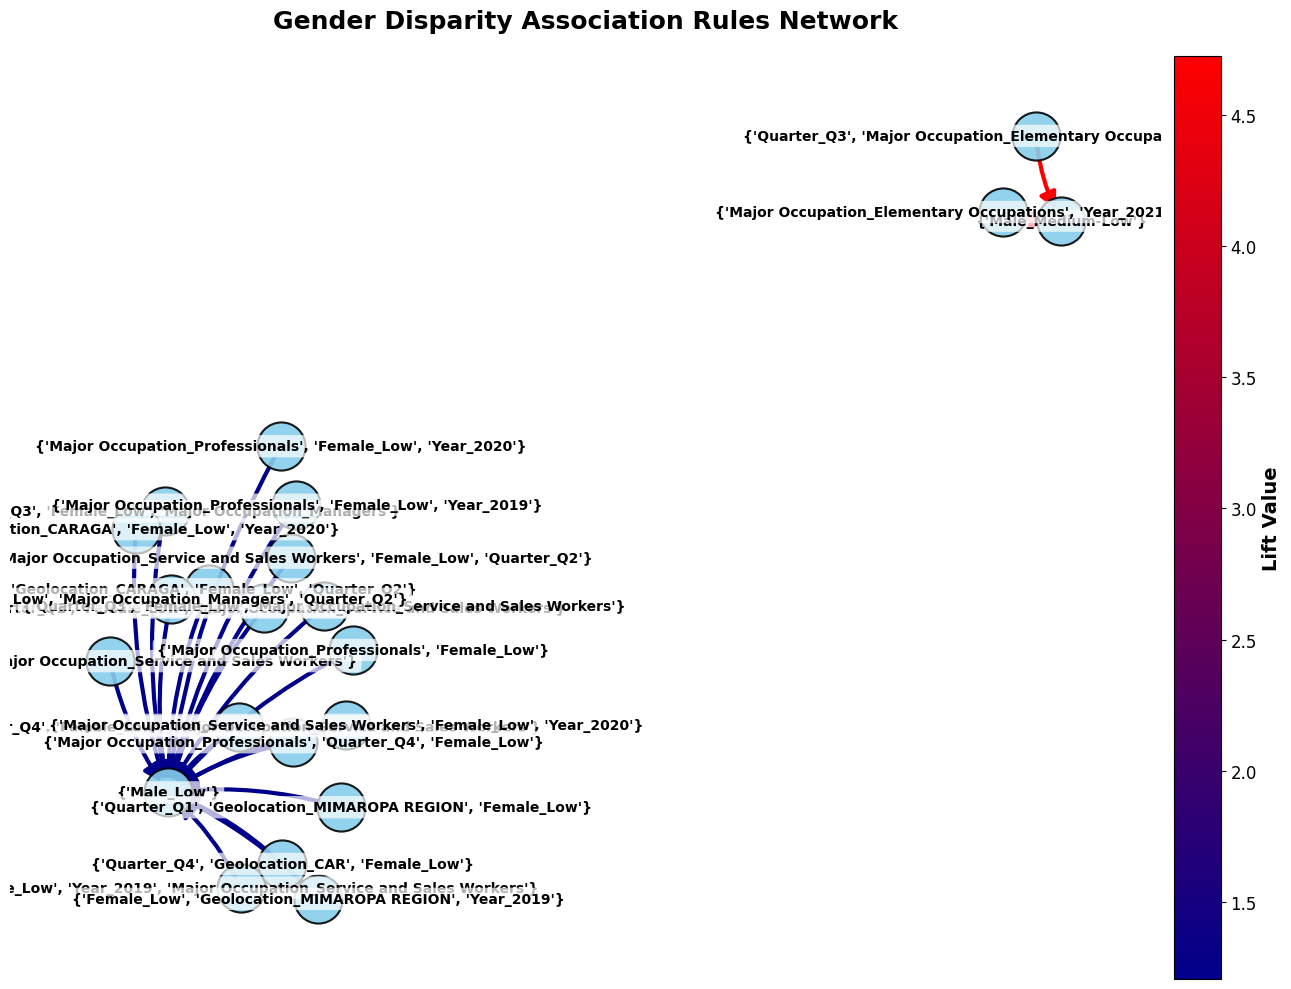

In [15]:
# Create a network graph visualization of association rules

import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

# Create a function to visualize rules as a network graph
def visualize_rules_network(rules, min_lift=1.0, max_rules=50, title="Association Rules Network"):
    """
    Visualize association rules as a network graph
    
    Parameters:
    -----------
    rules : pandas DataFrame
        DataFrame containing association rules
    min_lift : float
        Minimum lift value to include in visualization
    max_rules : int
        Maximum number of rules to visualize
    title : str
        Title for the network graph
    """
    # Filter rules by lift
    filtered_rules = rules[rules['lift'] >= min_lift].sort_values('lift', ascending=False).head(max_rules)
    
    if len(filtered_rules) == 0:
        print("No rules meet the criteria for visualization")
        return
    
    # Create a directed graph
    G = nx.DiGraph()
    
    # Add edges for each rule
    for _, rule in filtered_rules.iterrows():
        # Convert frozensets to strings and clean up for display
        antecedent = str(rule['antecedents']).replace('frozenset(', '').replace(')', '').strip('()')
        consequent = str(rule['consequents']).replace('frozenset(', '').replace(')', '').strip('()')
        
        # Add nodes if they don't exist
        if antecedent not in G.nodes:
            G.add_node(antecedent)
        if consequent not in G.nodes:
            G.add_node(consequent)
        
        # Add edge with attributes
        G.add_edge(antecedent, consequent, 
                  weight=rule['lift'],
                  confidence=rule['confidence'],
                  support=rule['support'])
    
    # Create figure and axis explicitly to fix colorbar issue
    fig, ax = plt.subplots(figsize=(14, 10))
    
    # Define node positions using spring layout
    pos = nx.spring_layout(G, k=0.3, iterations=50)
    
    # Define color map for edges based on lift
    edge_colors = [G[u][v]['weight'] for u, v in G.edges()]
    vmin = min(edge_colors) if edge_colors else 1.0
    vmax = max(edge_colors) if edge_colors else 2.0
    
    # Create custom colormap (blue to red) - more vibrant colors
    cmap = LinearSegmentedColormap.from_list('lift_cmap', ['darkblue', 'red'])
    
    # Draw nodes with larger size and more visible colors
    nx.draw_networkx_nodes(G, pos, node_size=1200, node_color='skyblue', 
                          edgecolors='black', linewidths=1.5, alpha=0.9, ax=ax)
    
    # Draw edges with thicker lines and more pronounced colors
    edges = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=3, 
                                  edge_cmap=cmap, edge_vmin=vmin, edge_vmax=vmax,
                                  arrowsize=25, connectionstyle='arc3,rad=0.1', ax=ax)
    
    # Draw labels with larger font and better contrast
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', 
                           font_color='black', bbox=dict(facecolor='white', alpha=0.7, 
                                                       edgecolor='none', boxstyle='round,pad=0.3'), ax=ax)
    
    # Add colorbar with explicit axis reference and better formatting
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Lift Value', pad=0.01)
    cbar.ax.tick_params(labelsize=12)
    cbar.set_label('Lift Value', size=14, weight='bold')
    
    # Add a more prominent title
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')
    
    # Add a border around the plot for better visibility
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('gray')
        spine.set_linewidth(2)
    
    plt.tight_layout()
    return G

# Visualize gender-related rules with a more prominent header
print("\n" + "="*80)
print("NETWORK VISUALIZATION OF GENDER-RELATED RULES")
print("="*80)
gender_rules_graph = visualize_rules_network(
    gender_rules, 
    min_lift=1.2, 
    max_rules=30, 
    title="Gender Association Rules Network"
)

# Visualize gender disparity rules if they exist
try:
    # Create rules_df if it doesn't exist yet
    if 'rules_df' not in locals() and 'rules_df' not in globals():
        rules_df = rules  # Assuming 'rules' is the main rules DataFrame
        
    # Filter and visualize gender disparity rules
    gender_disparity_rules = rules_df[
        ((rules_df['antecedents'].astype(str).str.contains('Male')) & 
         (rules_df['consequents'].astype(str).str.contains('Female'))) |
        ((rules_df['antecedents'].astype(str).str.contains('Female')) & 
         (rules_df['consequents'].astype(str).str.contains('Male')))
    ].sort_values('lift', ascending=False)
    
    if len(gender_disparity_rules) > 0:
        print("\n" + "="*80)
        print("NETWORK VISUALIZATION OF GENDER DISPARITY RULES")
        print("="*80)
        disparity_graph = visualize_rules_network(
            gender_disparity_rules, 
            min_lift=1.0, 
            max_rules=20, 
            title="Gender Disparity Association Rules Network"
        )
    else:
        print("\n" + "="*80)
        print("NO GENDER DISPARITY RULES FOUND FOR VISUALIZATION")
        print("="*80)
except Exception as e:
    print("\n" + "="*80)
    print(f"ERROR: Could not create gender disparity network: {e}")
    print("="*80)



RULES WITH HIGHEST LIFT VALUES
                                           antecedents  \
633                               (Female_Medium-High)   
631                      (Male_Low, Female_Medium-Low)   
173  (Quarter_Q3, Major Occupation_Elementary Occup...   
181  (Major Occupation_Elementary Occupations, Year...   
536                      (Quarter_Q4, Geolocation_CAR)   
586                    (Geolocation_CARAGA, Year_2021)   
288       (Major Occupation_Professionals, Quarter_Q3)   
298        (Major Occupation_Professionals, Year_2020)   
278       (Major Occupation_Professionals, Quarter_Q1)   
416  (Major Occupation_Technicians and Associate Pr...   

                                      consequents      lift  confidence  \
633  (Major Occupation_Service and Sales Workers)  9.615385    0.961538   
631  (Major Occupation_Service and Sales Workers)  6.153846    0.615385   
173                             (Male_Medium-Low)  4.725869    0.648649   
181                          

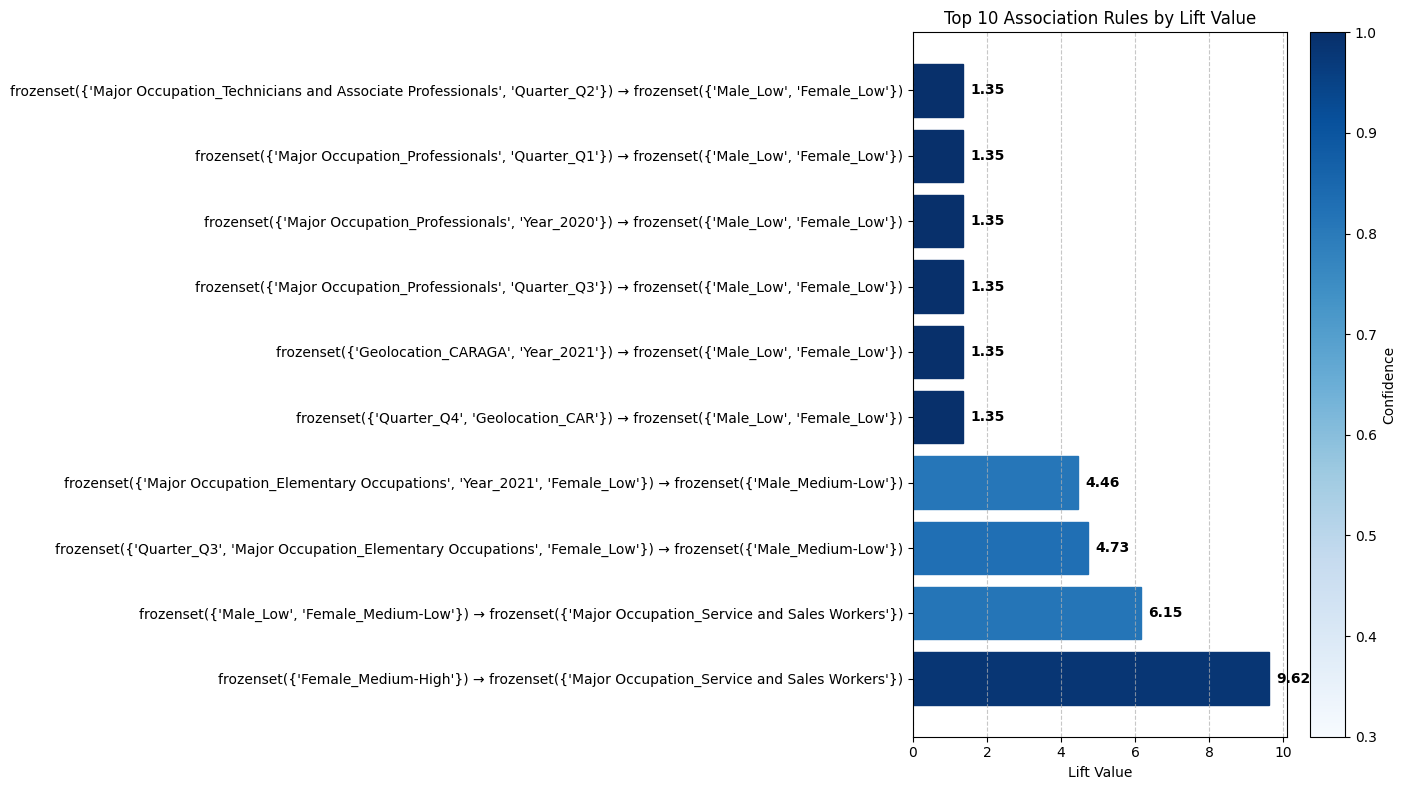

In [16]:
# Analyze rules with highest lift values
print("\n" + "="*80)
print("RULES WITH HIGHEST LIFT VALUES")
print("="*80)

# Sort rules by lift in descending order (not ascending) to get top 10
top_lift_rules = rules.sort_values('lift', ascending=False).head(10)
print(top_lift_rules[['antecedents', 'consequents', 'lift', 'confidence', 'support']])

# Create a visualization of top rules by lift
fig, ax = plt.subplots(figsize=(14, 8))

# Extract rule descriptions for x-axis labels
rule_labels = [f"{row['antecedents']} → {row['consequents']}" for _, row in top_lift_rules.iterrows()]

# Create horizontal bar chart with lift values
bars = ax.barh(range(len(top_lift_rules)), top_lift_rules['lift'], color='skyblue')

# Add lift values at the end of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{top_lift_rules.iloc[i]["lift"]:.2f}', 
             va='center', fontweight='bold')

# Set y-axis labels to rule descriptions
ax.set_yticks(range(len(top_lift_rules)))
ax.set_yticklabels(rule_labels)

# Add labels and title
ax.set_xlabel('Lift Value')
ax.set_title('Top 10 Association Rules by Lift Value')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add color coding based on confidence
for i, bar in enumerate(bars):
    # Color gradient based on confidence (darker = higher confidence)
    confidence = top_lift_rules.iloc[i]['confidence']
    bar.set_color(plt.cm.Blues(0.3 + 0.7 * confidence))

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(0.3, 1.0))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Confidence')

# Adjust layout to make room for rule labels
plt.tight_layout()



RULES WITH HIGHEST LIFT VALUES
                                           antecedents  \
633                               (Female_Medium-High)   
631                      (Male_Low, Female_Medium-Low)   
173  (Quarter_Q3, Major Occupation_Elementary Occup...   
181  (Major Occupation_Elementary Occupations, Year...   
536                      (Quarter_Q4, Geolocation_CAR)   
586                    (Geolocation_CARAGA, Year_2021)   
288       (Major Occupation_Professionals, Quarter_Q3)   
298        (Major Occupation_Professionals, Year_2020)   
278       (Major Occupation_Professionals, Quarter_Q1)   
416  (Major Occupation_Technicians and Associate Pr...   

                                      consequents      lift  confidence  \
633  (Major Occupation_Service and Sales Workers)  9.615385    0.961538   
631  (Major Occupation_Service and Sales Workers)  6.153846    0.615385   
173                             (Male_Medium-Low)  4.725869    0.648649   
181                          

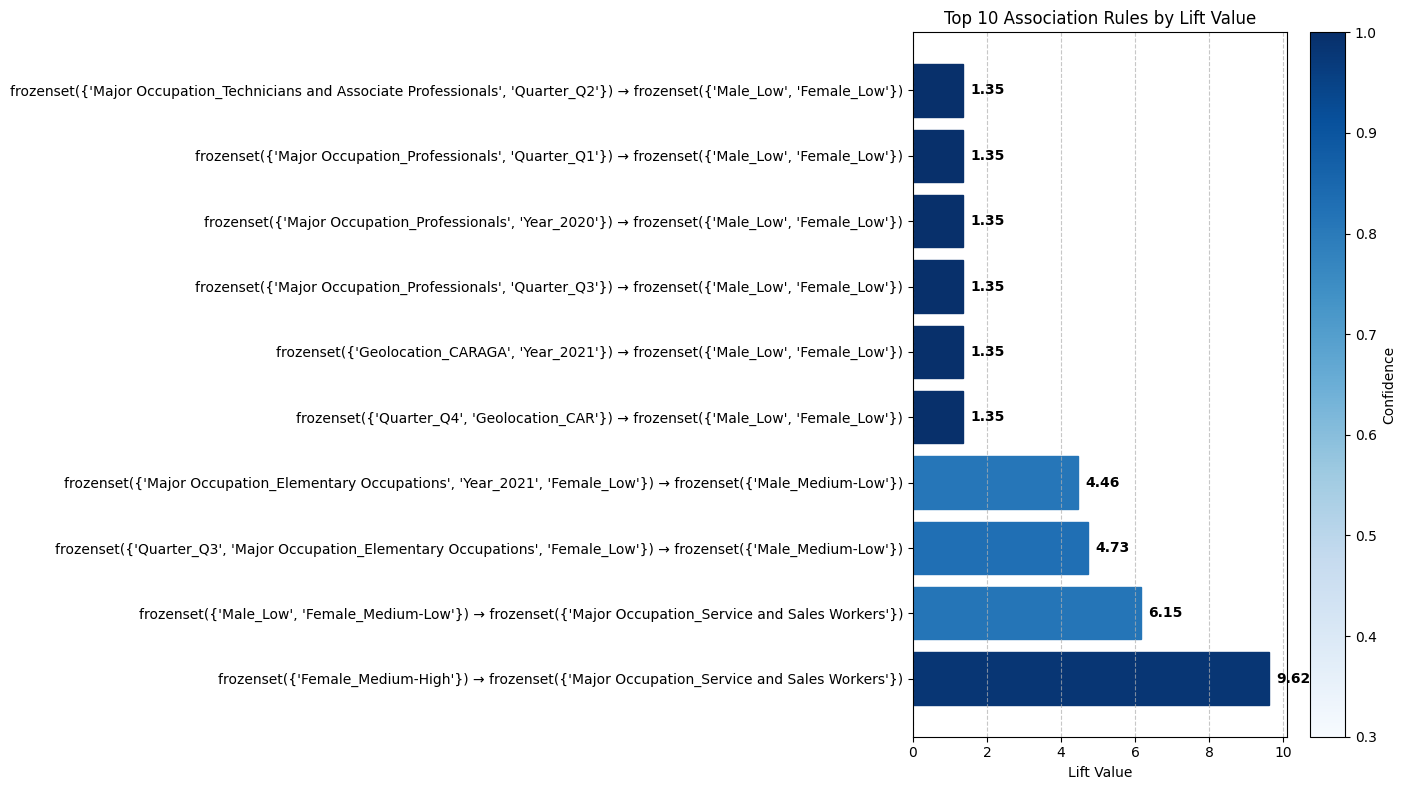

In [17]:
# Analyze rules with highest lift values
print("\n" + "="*80)
print("RULES WITH HIGHEST LIFT VALUES")
print("="*80)

# Sort rules by lift in descending order and get top 10
top_lift_rules = rules.sort_values('lift', ascending=False).head(10)
print(top_lift_rules[['antecedents', 'consequents', 'lift', 'confidence', 'support']])

# Create a visualization of top rules by lift
fig, ax = plt.subplots(figsize=(14, 8))

# Extract rule descriptions for y-axis labels
rule_labels = [f"{row['antecedents']} → {row['consequents']}" for _, row in top_lift_rules.iterrows()]

# Create horizontal bar chart with lift values
bars = ax.barh(range(len(top_lift_rules)), top_lift_rules['lift'], color='skyblue')

# Add lift values at the end of each bar
for i, bar in enumerate(bars):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, 
             f'{top_lift_rules.iloc[i]["lift"]:.2f}', 
             va='center', fontweight='bold')

# Set y-axis labels to rule descriptions
ax.set_yticks(range(len(top_lift_rules)))
ax.set_yticklabels(rule_labels)

# Add labels and title
ax.set_xlabel('Lift Value')
ax.set_title('Top 10 Association Rules by Lift Value')
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Add color coding based on confidence
for i, bar in enumerate(bars):
    # Color gradient based on confidence (darker = higher confidence)
    confidence = top_lift_rules.iloc[i]['confidence']
    bar.set_color(plt.cm.Blues(0.3 + 0.7 * confidence))

# Add a colorbar legend
sm = plt.cm.ScalarMappable(cmap=plt.cm.Blues, norm=plt.Normalize(0.3, 1.0))
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Confidence')

# Adjust layout to make room for rule labels
plt.tight_layout()



Top Gender Disparity Rules (Male → Female or Female → Male):
                                           antecedents        consequents  \
173  (Quarter_Q3, Major Occupation_Elementary Occup...  (Male_Medium-Low)   
181  (Major Occupation_Elementary Occupations, Year...  (Male_Medium-Low)   
565       (Geolocation_CARAGA, Female_Low, Quarter_Q2)         (Male_Low)   
524          (Geolocation_CAR, Female_Low, Quarter_Q2)         (Male_Low)   
539           (Geolocation_CAR, Female_Low, Year_2020)         (Male_Low)   
530          (Quarter_Q3, Female_Low, Geolocation_CAR)         (Male_Low)   
435  (Year_2021, Female_Low, Major Occupation_Techn...         (Male_Low)   
560                   (Geolocation_CARAGA, Female_Low)         (Male_Low)   
430  (Major Occupation_Technicians and Associate Pr...         (Male_Low)   
749     (Geolocation_REGION IX, Female_Low, Year_2019)         (Male_Low)   

     antecedent support  consequent support   support  confidence      lift  \
173        

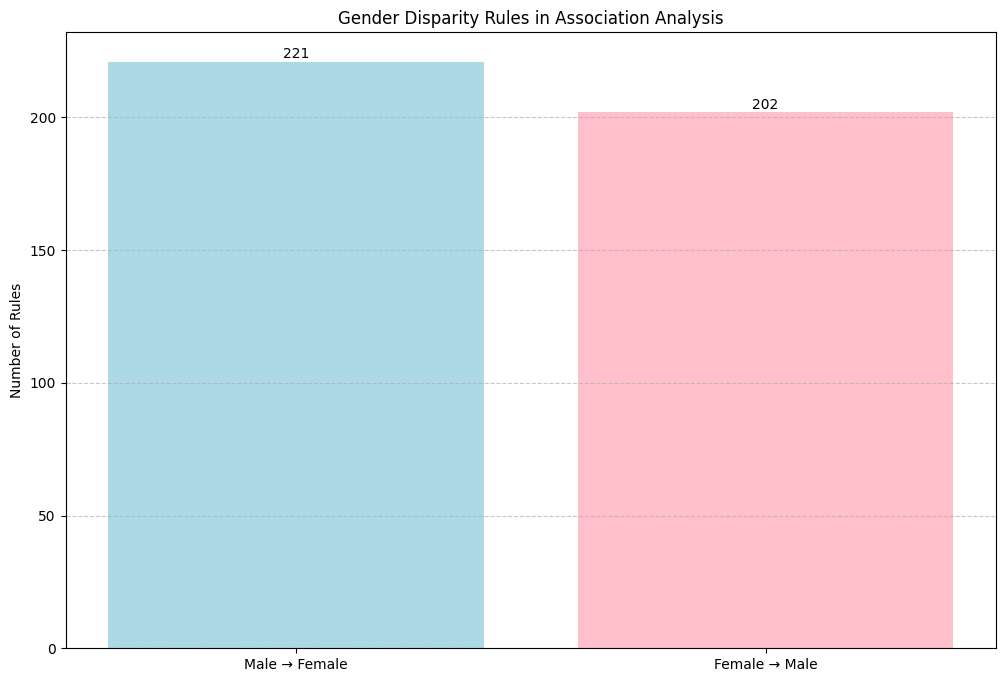

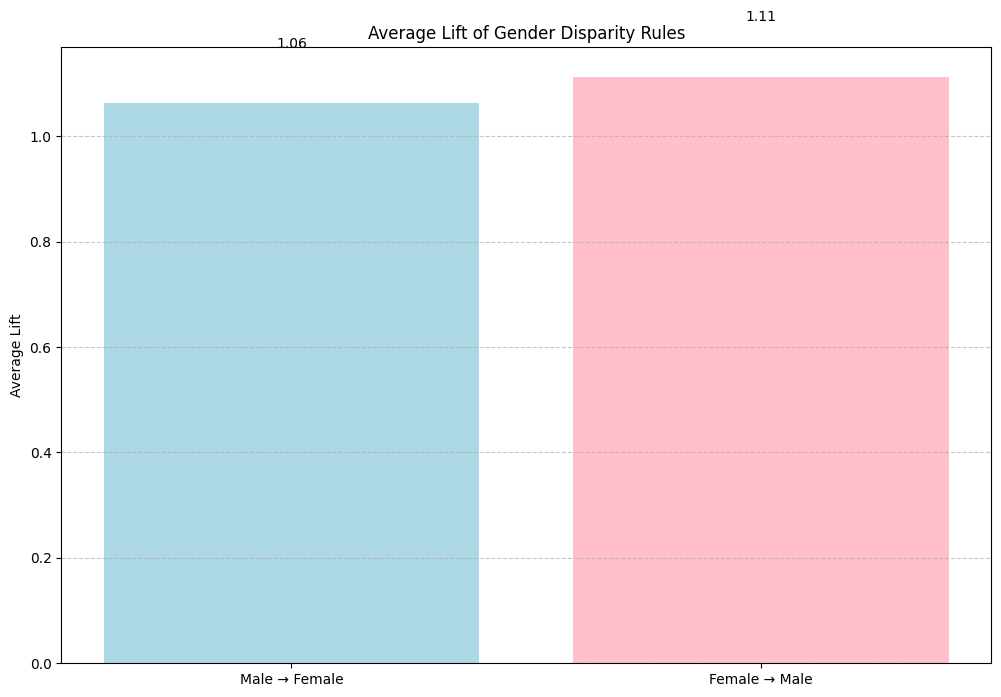

In [18]:
# Analyze gender disparities in association rules

# Filter rules that show direct gender disparities (male → female or female → male)
gender_disparity_rules = rules_df[
    ((rules_df['antecedents'].astype(str).str.contains('Male')) & 
     (rules_df['consequents'].astype(str).str.contains('Female'))) |
    ((rules_df['antecedents'].astype(str).str.contains('Female')) & 
     (rules_df['consequents'].astype(str).str.contains('Male')))
].sort_values('lift', ascending=False)

# Display the top gender disparity rules
print("\nTop Gender Disparity Rules (Male → Female or Female → Male):")
print(gender_disparity_rules.head(10))

# Count the number of rules in each direction
male_to_female = gender_disparity_rules[
    (gender_disparity_rules['antecedents'].astype(str).str.contains('Male')) & 
    (gender_disparity_rules['consequents'].astype(str).str.contains('Female'))
]

female_to_male = gender_disparity_rules[
    (gender_disparity_rules['antecedents'].astype(str).str.contains('Female')) & 
    (gender_disparity_rules['consequents'].astype(str).str.contains('Male'))
]

# Calculate average lift for each direction
male_to_female_avg_lift = male_to_female['lift'].mean() if len(male_to_female) > 0 else 0
female_to_male_avg_lift = female_to_male['lift'].mean() if len(female_to_male) > 0 else 0

# Visualize gender disparities
plt.figure(figsize=(12, 8))
bars = plt.bar(['Male → Female', 'Female → Male'], 
        [len(male_to_female), len(female_to_male)],
        color=['lightblue', 'pink'])

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height}', ha='center', va='bottom')

plt.title('Gender Disparity Rules in Association Analysis')
plt.ylabel('Number of Rules')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add a second plot showing average lift
plt.figure(figsize=(12, 8))
bars = plt.bar(['Male → Female', 'Female → Male'], 
        [male_to_female_avg_lift, female_to_male_avg_lift],
        color=['lightblue', 'pink'])

# Add lift values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}', ha='center', va='bottom')

plt.title('Average Lift of Gender Disparity Rules')
plt.ylabel('Average Lift')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
